In [95]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from tensorflow.keras.callbacks import LambdaCallback 

## Prepare MNIST dataset

In [96]:
# Prepare MNIST data set from tensorflow
(x_train, y_train), (x_test, y_test) = mnist.load_data()
labels = [0,1,2,3,4,5,6,7,8,9]

In [97]:
# Pre-process data
img_rows, img_cols, channels = 28, 28, 1
classes = 10

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, img_rows, img_cols, channels))
x_test = x_test.reshape((-1, img_rows, img_cols, channels))

y_train = tf.keras.utils.to_categorical(y_train, classes)
y_test = tf.keras.utils.to_categorical(y_test, classes)

print("Data shapes", x_test.shape, y_test.shape, x_train.shape, y_train.shape)

Data shapes (10000, 28, 28, 1) (10000, 10) (60000, 28, 28, 1) (60000, 10)


## NN model

In [98]:
# Create model
def create_model():

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(3, 3), padding='same',activation='relu', input_shape=(img_rows, img_cols, channels)))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same',activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(3, 3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.2))
    # softmax classifier
    model.add(Dense(classes,activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

In [99]:
# Create and fit model
model = create_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 10, 10, 32)        320       
                                                                 
 conv2d_29 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 conv2d_30 (Conv2D)          (None, 2, 2, 64)          36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 1, 1, 64)         0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                     

In [100]:
model.fit(x_train, y_train,epochs=20,validation_data=(x_test, y_test))

Epoch 1/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0149 - accuracy: 0.8967 - val_loss: 0.0056 - val_accuracy: 0.9633
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0062 - accuracy: 0.9599 - val_loss: 0.0041 - val_accuracy: 0.9723
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0049 - accuracy: 0.9687 - val_loss: 0.0039 - val_accuracy: 0.9737
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0040 - accuracy: 0.9744 - val_loss: 0.0035 - val_accuracy: 0.9777
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0036 - accuracy: 0.9771 - val_loss: 0.0031 - val_accuracy: 0.9801
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0032 - accuracy: 0.9797 - val_loss: 0.0032 - val_accuracy: 0.9796
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0029 - accuracy: 0.9815 - val_loss: 0.0031 - val_accuracy:

In [120]:
# Model evaluation
acc1 = model.evaluate(x=x_test, y=y_test, verbose=0)[1]*100
print("Model evaluation: " + str(round(acc1,2)) + "%")

Model evaluation: 98.29%


## Adversarial attack

In [102]:
# Create perturbation

#loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = tf.keras.losses.MeanSquaredError()

def create_perturbation(image, label):
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
        
    # Compute gradients
    gradient = tape.gradient(loss, image)
    # Compute the sign of the gradients for perturbation
    signed_grad = tf.sign(gradient)
    
    return signed_grad

Correct Label: 0
Prediction Label: 2


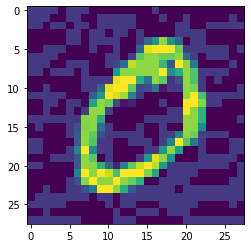

In [103]:
# Try to create a signle adversarial example
image = x_train[1]
image_label = y_train[1]
perturbations = create_perturbation(image.reshape((1, img_rows, img_cols, channels)), image_label).numpy()
adversarial = image + perturbations * 0.1

print("Correct Label: " + str(labels[model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()]))
print("Prediction Label: " + str(labels[model.predict(adversarial).argmax()]))

plt.imshow(adversarial.reshape((img_rows, img_cols, channels)))
plt.show()

In [104]:
# Adversarial generator
def generate_adversarials(batch_size):
    while True:
        x = []
        y = []
        z = []
        for batch in range(batch_size):
            n = random.randint(0, 100)

            label = y_train[n]
            image = x_train[n]
            
            perturbations = create_perturbation(image.reshape((1, img_rows, img_cols, channels)), label).numpy()
            
            epsilon = 0.1
            adversarial = image + perturbations * epsilon
            
            x.append(adversarial)
            y.append(y_train[n])
            z.append(x_train[n])
        
        x = np.asarray(x).reshape((batch_size, img_rows, img_cols, channels))
        y = np.asarray(y)
        #original image
        z = np.asarray(z).reshape((batch_size, img_rows, img_cols, channels))
        
        yield x, y, z

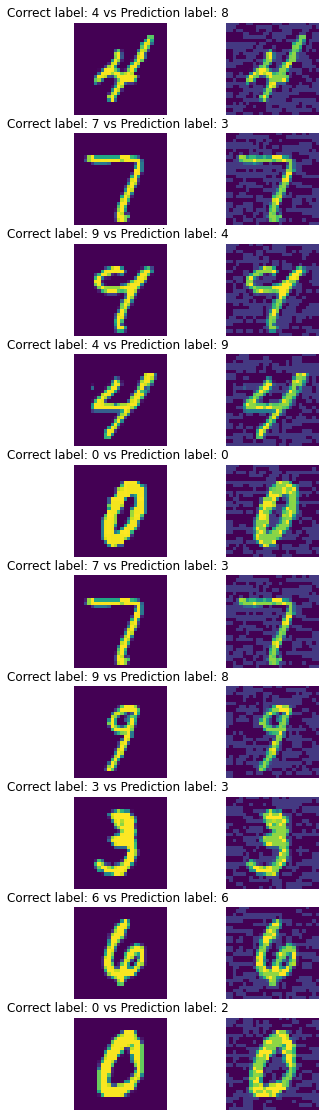

<Figure size 360x360 with 0 Axes>

In [105]:
# Generate and show sample 10 images
adversarials, correct_labels, original_images = next(generate_adversarials(20))   
f, axarr = plt.subplots(10, 2, figsize=(5,20))
plt.figure(figsize=[5,5])
for i in range(10):
    a = labels[model.predict(adversarials[i].reshape((1, img_rows, img_cols, channels))).argmax()]
    b = labels[correct_labels[i].argmax()]
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,0].set_title("Correct label: %s vs Prediction label: %s " % (b,a))
    axarr[i,0].imshow(original_images[i].reshape(img_rows, img_cols))
    axarr[i,1].imshow(adversarials[i].reshape(img_rows, img_cols))
plt.show()

In [106]:
# Generate adversarial data
x_adversarial_train, y_adversarial_train, x_original_train = next(generate_adversarials(20000))
x_adversarial_test, y_adversarial_test, x_original_test = next(generate_adversarials(10000))

In [117]:
# Adversarial attack model evaluation
acc2 = model.evaluate(x=x_adversarial_test, y=y_adversarial_test, verbose=0)[1]*100
print("Adversarial attack model evaluation: " + str(round(acc2,2)) + "%")

Adversarial attack model evaluation: 18.66%
